# Preparação do ambiente

## Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import unidecode
import warnings 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from string import punctuation

from tabulate import tabulate

from wordcloud import WordCloud

In [2]:
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore')

In [3]:
%%html
<style>
table {float:left}
</style>

## Constantes e funções auxiliares

In [4]:
NULL_STRING = '#NULLO#'
MAX_CAT_COUNT = 3

In [5]:
def plot_donut(labels,values,title,startangle=30):
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw=dict(aspect="equal"))
    
    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), startangle=startangle)
    
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props,
              zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    
    ax.set_title(title)
    plt.show()

In [6]:
def tokenizer(doc):
    doc = doc.lower()
    doc = unidecode.unidecode(doc)
    
    # uniformizar termos
    patterns = [('wi\s?.?fi', 'wifi'), 
                ('2,4', '2.4'), 
                ('5,8', '5.8')]
    for pattern, repl in patterns:
        doc = re.sub(pattern, repl, doc)
    
    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(punctuation))
    # stopwords específicas do domínio
    stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver', 'unidades', 'fio', 'universal'])
    # cores mais comumns
    stop_words.extend(['preto', 'cinza', 'branco', 'rosa', 'vermelho', 'laranja', 'amarelo', 'verde', 'azul', 'roxo', 'marrom'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", que pode ser relevante para o domínio
    # stop_words.remove('sem') 
    
    tokens = [token for token in word_tokenize(doc) if token not in stop_words]
    return tokens

def doc_cleaner(doc):
    tokens = tokenizer(doc)
    return ' '.join(tokens) 

In [7]:
def plot_docs_matrix(docs_matrix, true_targets=None, predicted_targets=None, title=None):
    pca = TruncatedSVD(n_components=2)
    pca_matrix = pca.fit_transform(docs_matrix)
    scatter_x = pca_matrix[:, 0] # first principle component
    scatter_y = pca_matrix[:, 1] # second principle component
    
    if predicted_targets is None:
        fig,ax = plt.subplots(figsize=(6,5))
        if true_targets is not None:
            for group in np.unique(true_targets):
                ix = np.where(true_targets == group)
                ax.scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
                if title is None:
                    ax.set_title('Documentos por categoria\n(Real)')   
                else:
                    ax.set_title(title)
        else:
            ax.scatter(scatter_x, scatter_y, s=5)
            if title is None:
                ax.set_title('Documentos')
            else:
                ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        
    else:
        fig,axs = plt.subplots(1,2,figsize=(12,5))
        if true_targets is not None:
            for group in np.unique(true_targets):
                ix = np.where(true_targets == group)
                axs[0].scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
                if title is None:
                    axs[0].set_title('Documentos por categoria\n(Real)')   
                else:
                    axs[0].set_title(title)
        else:
            axs[0].scatter(scatter_x, scatter_y, s=5)
            if title is None:
                axs[0].set_title('Documentos')
            else:
                axs[0].set_title(title)
        
        for group in np.unique(predicted_targets):
            ix = np.where(predicted_targets == group)
            axs[1].scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
            axs[1].set_title('Agrupamento por categoria\n(K-Means)')

        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])
        
    plt.show()

In [8]:
def plot_produtcs_matrix(docs_matrix, targets=None, title=None, legend_map=None, ax=None):
    pca = TruncatedSVD(n_components=2)
    pca_matrix = pca.fit_transform(docs_matrix)
    scatter_x = pca_matrix[:, 0] # first principle component
    scatter_y = pca_matrix[:, 1] # second principle component

    if ax is None:
        fig,ax = plt.subplots(figsize=(6,5))
        showplot = True
    else:
        showplot = False
    for group in np.unique(targets):

        if legend_map is not None:
            group_label = legend_map[group]
        else:
            group_label = group
        
        ix = np.where(targets == group)
        ax.scatter(scatter_x[ix], scatter_y[ix], label=group_label, s=5)
        if title is not None:
            ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.legend()

    if showplot:
        plt.show()

In [9]:
def plot_wordcloud(wc_docs,max_words=50,ax=None,title='Principais palavras'):

    if hasattr(wc_docs, '__iter__'):
        wc_docs = ' '.join(wc_docs)
   
    wc = WordCloud(max_words=max_words,height=300).generate(wc_docs)

    if ax is None:
        fig,ax = plt.subplots(figsize=(5,5))
        show_plt = True
    else: 
        show_plt = False
    
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title)

    if show_plt:
        plt.show()

# Carga e prepação dos dados

In [10]:
raw_amazon_dataset = '../datasets/amazon_reindexed.parquet'
df_amazon = pd.read_parquet(raw_amazon_dataset)
df_amazon.head()

,Link,Palavra_Chave,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,Marca,Modelo,...,Vendedor,Data_Inclusão,Ativo,Descrição_Principal,Link_Vendedor,Preço_Original,Qtd_disponível,Qtd_vendidos,Desconto,Estado
0,https://www.amazon.com.br/Especiais-Cinematic-...,drone,Eletrônicos e Tecnologia,Câmeras e Foto,Acessórios,Filtros,#NULLO#,#NULLO#,Odorkle,#NULLO#,...,Lantacy,2024-03-06 01:49:12,True,Modelo aplicável: este filtro de listras azuis...,https://www.amazon.com.br/gp/help/seller/at-a-...,#NULLO#,#NULLO#,#NULLO#,#NULLO#,#NULLO#
1,https://www.amazon.com.br/Motores-Escova-Conju...,drone,Eletrônicos e Tecnologia,Câmeras e Foto,Acessórios,Acessórios para Drones,#NULLO#,#NULLO#,Airshi,Airshimowq96xigy-11,...,Aiterwu,2024-03-06 01:49:00,True,Fonte de alimentação: este motor sem escova de...,https://www.amazon.com.br/gp/help/seller/at-a-...,#NULLO#,#NULLO#,#NULLO#,#NULLO#,#NULLO#
2,https://www.amazon.com.br/Armazenamento-Protet...,drone,Brinquedos e Jogos,Brinquedos de Controle Remoto,#NULLO#,#NULLO#,#NULLO#,#NULLO#,Zhjvihx,#NULLO#,...,Zhjvihx-US,2024-03-06 01:48:46,True,Válvula de Alívio de Pressão: Equipada com vál...,https://www.amazon.com.br/gp/help/seller/at-a-...,#NULLO#,#NULLO#,#NULLO#,#NULLO#,#NULLO#
3,https://www.amazon.com.br/EQUSS-V-strom-Motoci...,drone,Eletrônicos e Tecnologia,Câmeras e Foto,Acessórios,Acessórios para Drones,#NULLO#,#NULLO#,Equss,EQUSS,...,Dengzhoushilianzhouqichepeijianshanghang,2024-03-06 01:48:26,True,"[Super Grip] - Design criativo, quatro suporte...",https://www.amazon.com.br/gp/help/seller/at-a-...,#NULLO#,#NULLO#,#NULLO#,#NULLO#,#NULLO#
4,https://www.amazon.com.br/remote-control-brush...,drone,Eletrônicos e Tecnologia,Câmeras e Foto,Acessórios,Acessórios para Drones,#NULLO#,#NULLO#,Uxsiya,Uxsiyay49ekqxi1t,...,Mseinope-US,2024-03-06 01:48:14,True,#NULLO#,https://www.amazon.com.br/gp/help/seller/at-a-...,#NULLO#,#NULLO#,#NULLO#,#NULLO#,#NULLO#


# Análise

## Dados brutos da Amazon

### Categorias definidas pelos vendedores

Os dados brutos da Amazon contém 151.782 registros, desdes, 100.406 não possuem categorias definidas pelos vendedores enquanto os demais estão distribuídos em outras 30 categorias primárias. 

Quase a totalidade dos dados estão distribuídos em duas categorias princiais: 97,8% dos produtos pertencem às categorias "Eletrônicos e Tecnologia" ou "Computadores e Informática"

In [11]:
columns_to_keep = ['cat_0', 'Nome']
df_categories = df_amazon[columns_to_keep].groupby('cat_0',as_index=False).count().sort_values(by='Nome',ascending=False)
df_categories = df_categories.reset_index(drop=True)
df_categories.columns = ['cat_0', 'count']

map_cat_0 = {k:(v if v < MAX_CAT_COUNT else MAX_CAT_COUNT) for v,k in df_categories.cat_0.to_dict().items()}
df_categories['cat_0_int'] = df_categories['cat_0'].map(map_cat_0)

df_categories['cum_sum'] = df_categories['count'].cumsum()
df_categories['cum_part'] = df_categories['cum_sum'].apply(lambda x: x/df_categories['count'].sum()*100)

columns_to_keep = ['cat_0_int', 'count']
df_top_categories = df_categories[columns_to_keep].groupby('cat_0_int',as_index=False).sum()
map_cat_0_int = {0: 'Sem categoria', 1: 'Eletrônicos e Tecnologia', 2: 'Computadores e Informática', 3: 'Outras'}
df_top_categories['top_cat'] = df_top_categories['cat_0_int'].map(map_cat_0_int)

columns_to_keep = ['top_cat', 'count']
df_top_categories = df_top_categories.set_index('cat_0_int')
df_top_categories = df_top_categories[columns_to_keep]

columns_to_keep = ['Categoria', 'Quantidade']
df_top_categories.columns = columns_to_keep

print(tabulate(df_top_categories,showindex=False,headers=columns_to_keep,intfmt=',',tablefmt='rounded_grid').replace(',','.'))

╭────────────────────────────┬──────────────╮
│ Categoria                  │   Quantidade │
├────────────────────────────┼──────────────┤
│ Sem categoria              │      100.406 │
├────────────────────────────┼──────────────┤
│ Eletrônicos e Tecnologia   │       39.062 │
├────────────────────────────┼──────────────┤
│ Computadores e Informática │       11.194 │
├────────────────────────────┼──────────────┤
│ Outras                     │        1.120 │
╰────────────────────────────┴──────────────╯


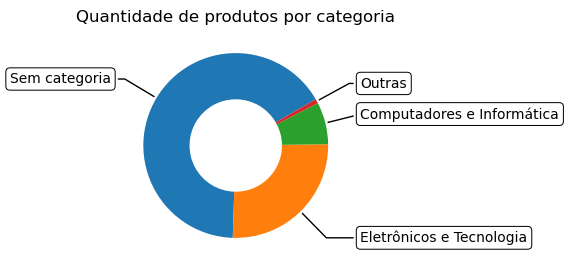

In [12]:
labels = df_top_categories['Categoria'].to_numpy()
values = df_top_categories['Quantidade'].to_numpy()
title = 'Quantidade de produtos por categoria'
startangle = 30

plot_donut(labels, values, title, startangle)

### Documentos no espaço vetorial agrupados por categoria

A visualização dos documentos no espaço vetorial, considerando tanto o título do anúncio quanto a descrição, quando existente, mostrou que as categorias indicadas pelos vendedores podem não ser um bom fator discriminante pois há grande sobreposição de categorias de documentos. 

A aplicação do algortimo de agrupamento K-Means refletiu a sobreposição das categorias e agrupou documentos com categorias sobrepostas em um mesmo grupo.

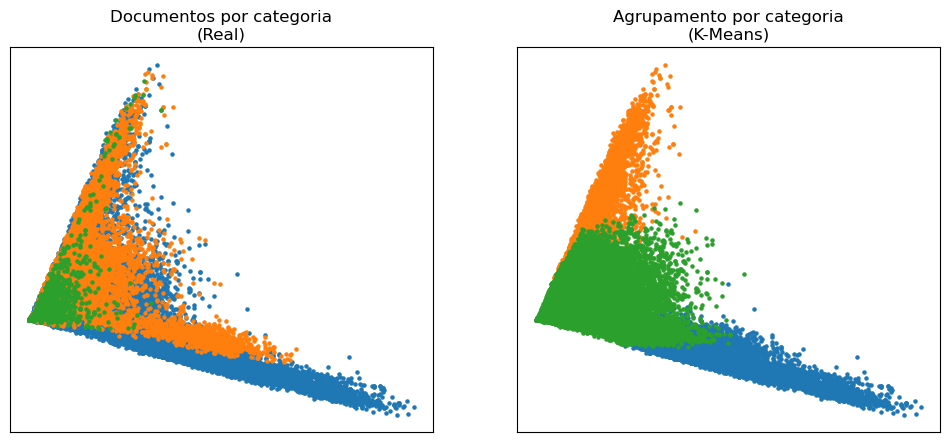

In [13]:
columns_to_keep = ['Nome','cat_0']
df_docs = df_amazon[df_amazon['cat_0']!=NULL_STRING][columns_to_keep]
df_docs['cat_0'] = df_docs['cat_0'].map(map_cat_0)

docs = df_docs['Nome']
targets = df_docs['cat_0']

vectorizer = TfidfVectorizer(tokenizer=tokenizer)
docs_matrix = vectorizer.fit_transform(docs)

kmeans_nome = KMeans(n_clusters=3, max_iter=500, n_init=1).fit(docs_matrix)
predicted_targets = kmeans_nome.labels_

plot_docs_matrix(docs_matrix,true_targets=targets,predicted_targets=predicted_targets)

Observando as principais palavras das categorias e dos grupos (clusters) obtidos através do K-Means, verifica-se mais uma indicação de que as categorias indicadas podem não ser mais adequadas para separação dos produtos. 

Observa-se, por exemplo, que as palavras transmissor e wifi são relevantes para as categorias 2 e 3, fone e ouvido para as categorias 1 e 2. 

Nos grupos (clusters) preditos pelo K-Means fica como primeira precepção que um grupo contém telefones celulares e acessórios, outro contém carregadores e baterias e o terceiro produtos relacionados a aúdio.

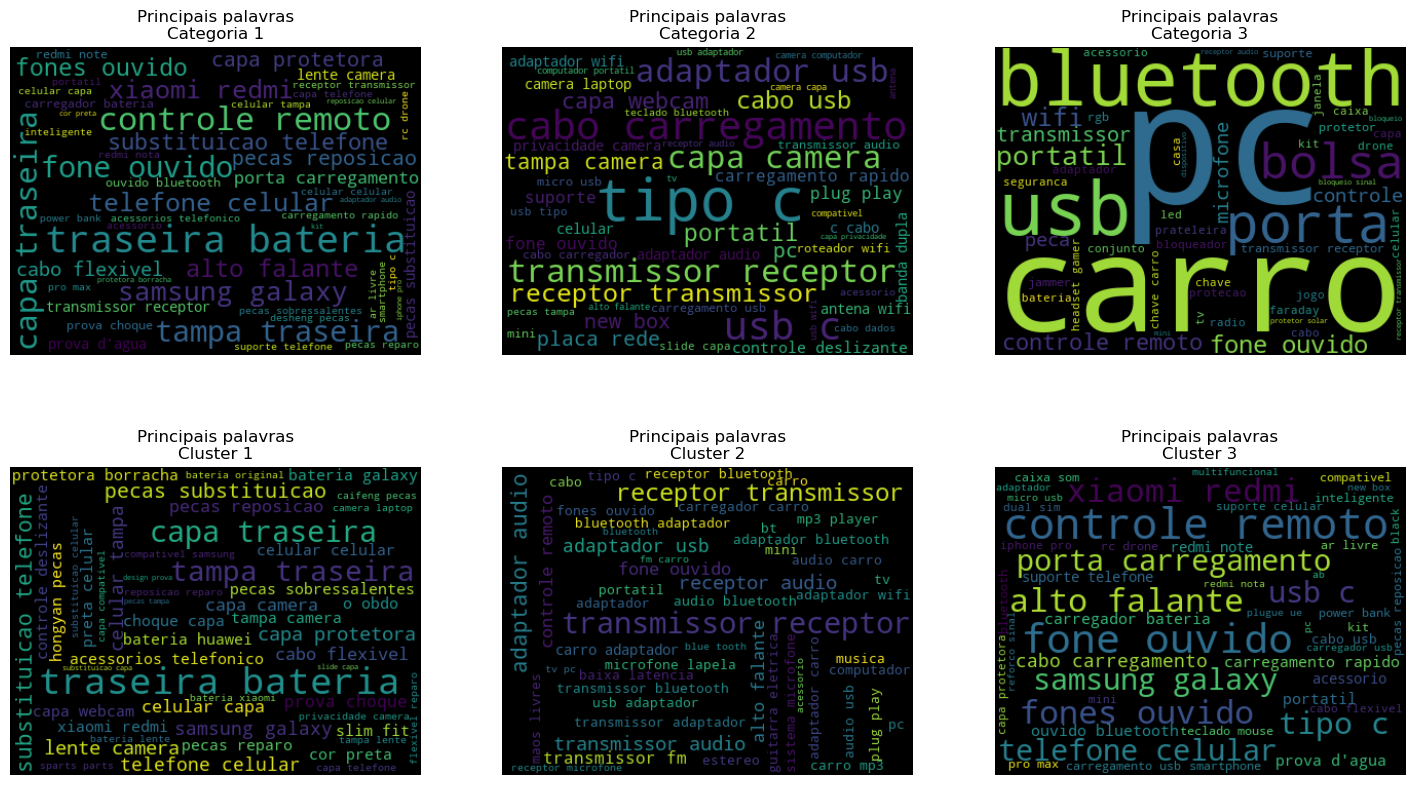

In [14]:
clean_docs = docs.map(doc_cleaner).values

fig,axs=plt.subplots(2,3,figsize=(18,10))

for i,target in enumerate(np.unique(targets)):
    ix = np.where(targets==target)[0]
    plot_wordcloud(clean_docs[ix],ax=axs[0][i],title=f'Principais palavras\nCategoria {i+1}')

for i,target in enumerate(np.unique(predicted_targets)):
    ix = np.where(predicted_targets==target)[0]
    plot_wordcloud(clean_docs[ix],ax=axs[1][i],title=f'Principais palavras\nCluster {i+1}')
    
plt.show()

## Amostra dos dados brutos

Como alternativa à utilização das categorias informadas pelos vendedores foi selecionada uma amostra de até 10 exemplos de cada categoria completa (categoria principal e até 5 subcategorias) para análise e anotação do tipo do produto. 

Foram selecionados e anotados 2.091 exemplos, em 29 tipo de produt. A maioria dos produtos diversos, ou seja, não destinados a telecomunicações foram classificados como Outros. Produtos para telecomunicações foram classificados conforme o tipo, além desses, produtos diversos em quantidade relevante foram classificados conforme o tipo.
 

|Tipo de Produto|Quantidade|
|:--------------|---------:|
|Outros|943|
|Transceptor de Radiação Restrita|599|
|Cabo (em geral)|89|
|Transceptor de RF (HF/VHF/UHF)|48|
|Microfone sem fio|38|
|Desktop/Notebook|30|
|Fone de ouvido sem fio|30|
|Carregadores e fontes (eletrônicos em geral)|27|
|Câmera sem fio|26|
|Carregador de celular|26|
|Impressora e cartuchos|25|
|Roteador/Reforçador WiFi|25|
|Antena|23|
|Baterias (eletrônicos em geral)|21|
|Extensor de vídeo VGA/HDMI|18|
|Tablets|16|
|Carregador sem fio|14|
|Telefone celular|14|
|Transceptor/Conversor SFP|14|
|Cartão de memória|13|
|Drone|12|
|Smartwatch|10|
|Carregador portátil (powerbank)|9|
|Cabo de rede|6|
|Reforçador de sinal de celular|5|
|Smart TV|4|
|Hub Switch|2|
|Modem 3G/4G/WiFi|2|
|TV Box|2|

A grande quantidade de tipos de produtos com poucos exemplos torna o processo de aprendizagem de máquina pois há grande sobreposição de exemplos, tornando difícil a correta identificação do produto.

Esse cenário já era esperado pois alguns tipos de produtos podem ser detinados para telecomunicações em determinados cenários e não destinados a telecomunicações em outros cenários, como por exemplos, cabos, fontes, carregadores, baterias, etc.

### Amostra dos documentos no espaço vetorial agrupados por tipo de produto

A visualização da amostra dos documentos no espaço vetorial mostrou que há sobreposição de tipos de produtos com poucos exemplos ao passo que indicou a possibiliade de separação em dois ou três grupos.

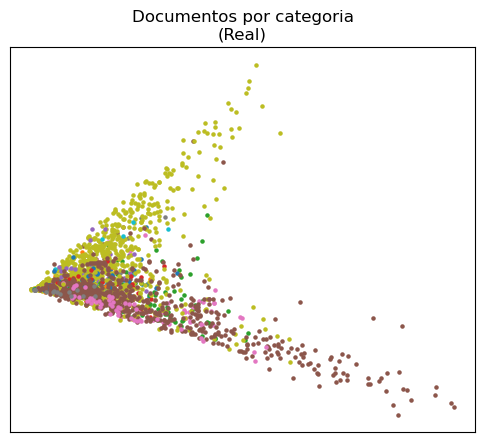

In [15]:
file_cat_sample = '../datasets/cat_to_label_sample.xlsx'
df_cat_sample = pd.read_excel(file_cat_sample)

df_cat_sample = df_cat_sample.iloc[:,-2:]
df_cat_sample = df_cat_sample.dropna()
df_cat_sample.columns = ['doc', 'labeled_category']

map_category_to_int = {category:i for i,category in enumerate(df_cat_sample.labeled_category.unique())}
map_category_to_name = {i:category for category,i in map_category_to_int.items()}
df_cat_sample['category'] = df_cat_sample['labeled_category'].map(map_category_to_int)

docs = df_cat_sample['doc']
targets = df_cat_sample['category']

vectorizer = TfidfVectorizer(tokenizer=tokenizer)
docs_matrix = vectorizer.fit_transform(docs)

plot_docs_matrix(docs_matrix,true_targets=targets)

### Agrupamento em duas ou três classes

Os produtos da amostra foram reclassificados em duas categorias: produtos diversos e produtos para telecomunicações. Os produtos para telecomunicações foram classificados ainda em protudos transmissores de radiofrequencia e produtos não transmissores de radiofrequência.

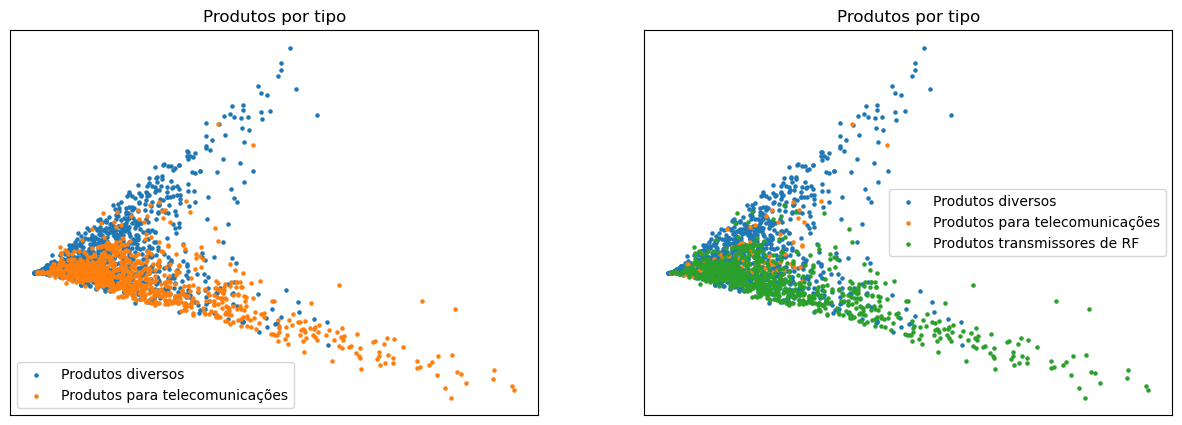

In [16]:
# df_cat_sample['clean_doc'] = df_cat_sample.doc.map(doc_cleaner)
# columns_to_keep = ['doc', 'clean_doc', 'labeled_category', 'telecom_product', 'rf_transmitter', 'category']
# df_cat_sample = df_cat_sample[columns_to_keep]

# df_cat_sample

map_telecom_product = {'Antena': 1,  
                       'Baterias (eletrônicos em geral)': 0, 
                       'Cabo (em geral)': 0, 
                       'Cabo de rede': 1, 
                       'Câmera sem fio': 1, 
                       'Carregador de celular': 1,
                       'Carregador portátil (powerbank)': 1,
                       'Carregador sem fio': 1, 
                       'Carregadores e fontes (eletrônicos em geral)': 0, 
                       'Cartão de memória': 0,
                       'Desktop/Notebook': 0, 
                       'Drone': 1, 
                       'Extensor de vídeo VGA/HDMI': 0, 
                       'Fone de ouvido sem fio': 1, 
                       'Hub Switch': 1, 
                       'Impressora e cartuchos': 0,
                       'Microfone sem fio': 1, 
                       'Modem 3G/4G/WiFi': 1, 
                       'Outros': 0, 
                       'Reforçador de sinal de celular': 1, 
                       'Roteador/Reforçador WiFi': 1, 
                       'Smart TV': 1,
                       'Smartwatch': 1, 
                       'Tablets': 1, 
                       'Telefone celular': 1, 
                       'Transceptor de Radiação Restrita': 1, 
                       'Transceptor de RF (HF/VHF/UHF)': 1, 
                       'Transceptor/Conversor SFP': 1, 
                       'TV Box': 1}

map_rf_transmitter = {'Antena': 1,  
                      'Baterias (eletrônicos em geral)': 0, 
                      'Cabo (em geral)': 0, 
                      'Cabo de rede': 1, 
                      'Câmera sem fio': 2, 
                      'Carregador de celular': 1,
                      'Carregador portátil (powerbank)': 1,
                      'Carregador sem fio': 1, 
                      'Carregadores e fontes (eletrônicos em geral)': 0, 
                      'Cartão de memória': 0,
                      'Desktop/Notebook': 0, 
                      'Drone': 2, 
                      'Extensor de vídeo VGA/HDMI': 0, 
                      'Fone de ouvido sem fio': 2, 
                      'Hub Switch': 1, 
                      'Impressora e cartuchos': 0,
                      'Microfone sem fio': 2, 
                      'Modem 3G/4G/WiFi': 2, 
                      'Outros': 0,                        
                      'Reforçador de sinal de celular': 2, 
                      'Roteador/Reforçador WiFi': 2, 
                      'Smart TV': 2,
                      'Smartwatch': 2, 
                      'Tablets': 2, 
                      'Telefone celular': 2, 
                      'Transceptor de Radiação Restrita': 2, 
                      'Transceptor de RF (HF/VHF/UHF)': 2, 
                      'Transceptor/Conversor SFP': 1, 
                      'TV Box': 2}

df_cat_sample['telecom_product'] = df_cat_sample['labeled_category'].map(map_telecom_product)
df_cat_sample['rf_transmitter'] = df_cat_sample['labeled_category'].map(map_rf_transmitter)

docs_sample = df_cat_sample['doc']
targets = df_cat_sample['telecom_product']
targets_rf = df_cat_sample['rf_transmitter']

vectorizer = TfidfVectorizer(tokenizer=tokenizer)
docs_matrix = vectorizer.fit_transform(docs_sample)

legend_map = {0: 'Produtos diversos', 1: 'Produtos para telecomunicações', 2: 'Produtos transmissores de RF'}

fig,axs = plt.subplots(1,2,figsize=(15,5))
plot_produtcs_matrix(docs_matrix,targets=targets,legend_map=legend_map,ax=axs[0],title='Produtos por tipo')
plot_produtcs_matrix(docs_matrix,targets=targets_rf,legend_map=legend_map,ax=axs[1],title='Produtos por tipo')
plt.show()

Quando agrupados em duas ou três categorias observa-se uma sepação entre os grupos, principalmente entre produtos diversos e produtos de telecomunicações transmissores de radiofrequência, indicando a viabilidade de construção de um classificador.

Quando observadas as palavras mais frequentes em cada categoria observa-se que há palavras discriminantes das categorias, contudo, palavras presentes em mais de uma categoria (cabo, bateria, etc) demonstram a sobreposição observada no espaço vetorial.

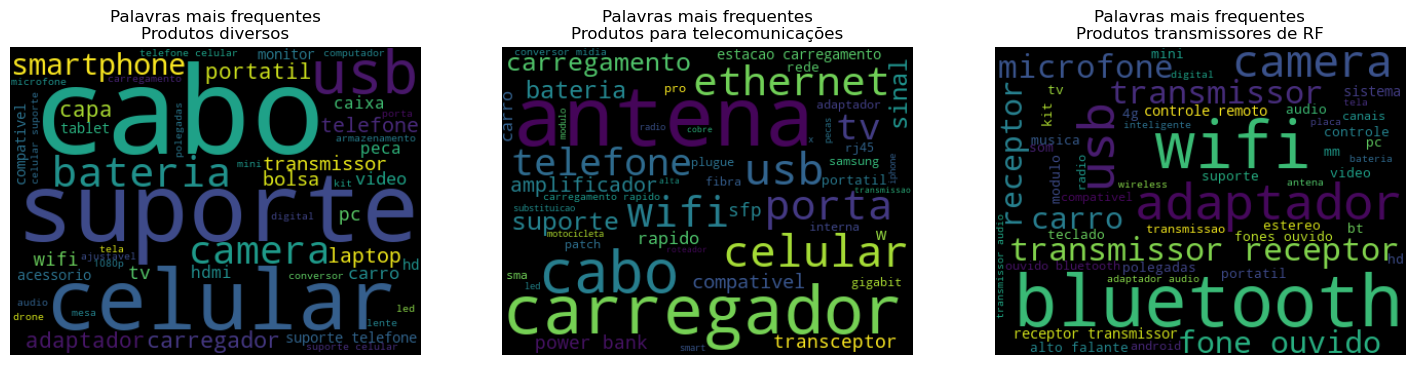

In [17]:
clean_docs_sample = df_cat_sample['doc'].map(doc_cleaner).values

fig,axs=plt.subplots(1,3,figsize=(18,10))

for i,target in enumerate(np.unique(targets_rf)):
    ix = np.where(targets_rf==target)[0]
    plot_wordcloud(clean_docs_sample[ix],ax=axs[i],title=f'Palavras mais frequentes\n{legend_map[i]}')

plt.show()

## Construção de classificadores

Foram contruídos dois classificadores para avaliação da viabilidade de separação dos produtos em dois ou três grupos distintos.

### Métricas de desempenho do classificador

Antes de apresentar os classificadores e resultados obtidos é necessário apresentar brevemente algumas métricas utilizadas para avaliação de seu desempenho.

O desempenho do classificador pode ser medido utilizando-se como base a matriz de confusão: uma tabela que apresenta a quantidade de exemplos corretamente e incorretamente classificados. 

Para classificações binária a matriz de confusão apresenta duas linhas e duas colunas que relatam a quantidade de de _falsos positivos (FP)_, _falsos negativos (FN)_, _verdadeiros positivos (VP)_ e _verdadeiros negativos (VN)_. Isso permite uma análise mais detalhada do que a mera proporção de classificações corretas.

![confusion](confusion_600.png)

A partir da matriz de confusão derivam-se duas medidas: precisão (_precision_) e sensibilidade (_recall_).

A precisão é uma métrica que avalia a quantidade de verdadeiros positivos sobre a soma de todos os valores positivos. Em outras palavras, é a capacidade do modelo de classificar corretamente os verdadeiros positivos, evitando falsos positivos.

$Precisão (Precision) = \frac{VP}{VP+FP}$ 

A sensbilidade avalia a capacidade do método de detectar com sucesso resultados classificados como positivos. Em outras palavras, é a capacidade do modelo de encontrar corretamente os verdadeiros positivos, evitando falsos negativos.

$Sensibilidade (Recall) = \frac{VP}{VP+FN}$


A curva ROC, do inglês Receiver Operating Characteristic Curve, ou na tradução “Curva Característica de Operação do Receptor” é um gráfico que permite avaliar um classificador binário. Essa visualização leva em consideração a taxa de verdadeiros positivos e a taxa de falsos positivos. Esse gráfico permite comparar diferentes classificadores e definir qual o melhor com base em diferentes pontos de corte. Na prática, quanto mais próximo do topo do eixo Y melhor o classificador.

![roc](roc_400.png)

Uma curva ROC pode ser avaliada pela métrica AUC (Area Under the Curve ou “área sob a curva”). AUC calcula a área da forma bidimensional formada abaixo da curva. Essa métrica indica a probabilidade de duas previsões serem corretamente ranqueadas. A AUC será um valor entre 0 e 1. Quanto maior esse valor, melhor a capacidade do modelo em separar classes.

Mais informações sobre métricas de desempenho de classificadores pode ser obtida em:

https://glossario.maiconramos.com/glossario/o-que-e-precision-and-recall-precisao-e-revocacao/

https://diegomariano.com/metricas-de-avaliacao-em-machine-learning/

https://medium.com/@ejunior029/principais-m%C3%A9tricas-de-classifica%C3%A7%C3%A3o-de-modelos-em-machine-learning-94eeb4b40ea9

### Classificador binário: produtos diversos vs produtos para telecomunicações

Accuracy of SGD classifier on training set: 0.936
Accuracy of SGD classifier on test set: 0.860
AUC of SGD classifier on test set: 0.931

                                precision    recall  f1-score   support

             Produtos diversos       0.85      0.91      0.88       303
Produtos para telecomunicações       0.87      0.79      0.83       220

                      accuracy                           0.86       523
                     macro avg       0.86      0.85      0.85       523
                  weighted avg       0.86      0.86      0.86       523



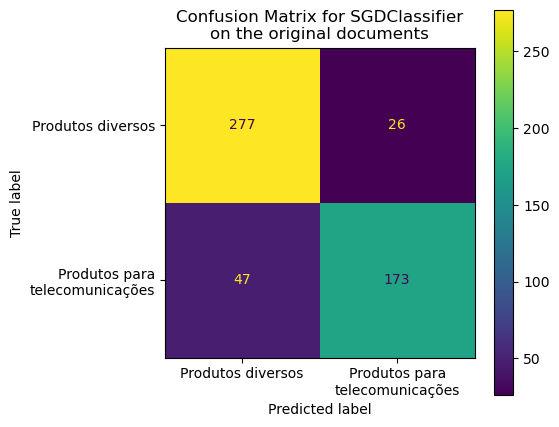

In [18]:
X = df_cat_sample['doc']
y = df_cat_sample['telecom_product']
target_names = ['Produtos diversos', 'Produtos para telecomunicações']
target_names_confusion = ['Produtos diversos', 'Produtos para\ntelecomunicações']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=724)

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizer)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

clf_sgd = SGDClassifier(loss='log_loss', penalty='l2',
                        alpha=1e-3, random_state=42,
                        max_iter=5, tol=None)

clf_sgd.fit(X_train_tfidf, y_train)
predicted = clf_sgd.predict(X_test_tfidf)

print('Accuracy of SGD classifier on training set: {:.3f}'
     .format(clf_sgd.score(X_train_tfidf, y_train)))
print('Accuracy of SGD classifier on test set: {:.3f}'
     .format(clf_sgd.score(X_test_tfidf, y_test)))
print('AUC of SGD classifier on test set: {:.3f}'
     .format(roc_auc_score(y_test,clf_sgd.predict_proba(X_test_tfidf)[:,1])))

print()
print(classification_report(y_test, predicted, target_names=target_names))

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_test, predicted, ax=ax)
ax.xaxis.set_ticklabels(target_names_confusion)
ax.yaxis.set_ticklabels(target_names_confusion)
_ = ax.set_title(f"Confusion Matrix for {clf_sgd.__class__.__name__}\non the original documents")


### Classificador de três classes: produtos diversos vs produtos para telecomunicações vs produtos emissores de RF

Accuracy of SGD classifier on training set: 0.910
Accuracy of SGD classifier on test set: 0.847

                                precision    recall  f1-score   support

             Produtos diversos       0.83      0.93      0.88       303
Produtos para telecomunicações       0.00      0.00      0.00        28
           Transmissores de RF       0.88      0.83      0.86       192

                      accuracy                           0.85       523
                     macro avg       0.57      0.59      0.58       523
                  weighted avg       0.80      0.85      0.82       523



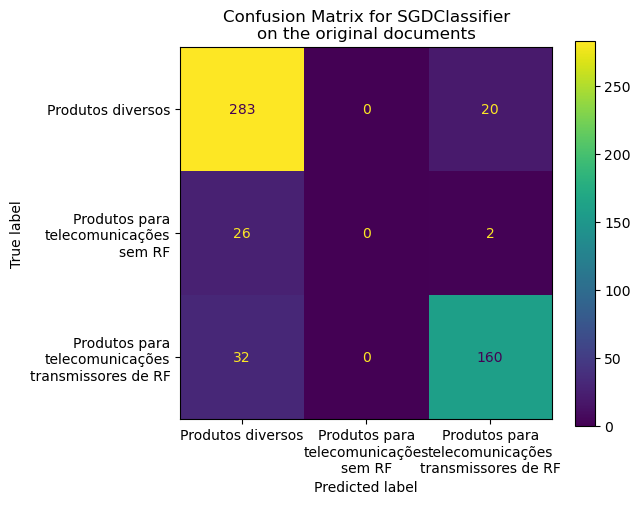

In [19]:
X = df_cat_sample['doc']
y = df_cat_sample['rf_transmitter']
target_names = ['Produtos diversos', 'Produtos para telecomunicações', 'Transmissores de RF']
target_names_confusion = ['Produtos diversos', 'Produtos para\ntelecomunicações\nsem RF', 'Produtos para\ntelecomunicações\ntransmissores de RF']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=724)

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizer)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

clf_sgd = SGDClassifier(loss='log_loss', penalty='l2',
                        alpha=1e-3, random_state=42,
                        max_iter=5, tol=None)

clf_sgd.fit(X_train_tfidf, y_train)
predicted = clf_sgd.predict(X_test_tfidf)

print('Accuracy of SGD classifier on training set: {:.3f}'
     .format(clf_sgd.score(X_train_tfidf, y_train)))
print('Accuracy of SGD classifier on test set: {:.3f}'
     .format(clf_sgd.score(X_test_tfidf, y_test)))

print()
print(classification_report(y_test, predicted, target_names=target_names))

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, predicted, ax=ax)
ax.xaxis.set_ticklabels(target_names_confusion)
ax.yaxis.set_ticklabels(target_names_confusion)
_ = ax.set_title(f"Confusion Matrix for {clf_sgd.__class__.__name__}\non the original documents")

### Classificador binário: produtos diversos vs transmissores de RF

Accuracy of SGD classifier on training set: 0.942
Accuracy of SGD classifier on test set: 0.891
AUC of SGD classifier on test set: 0.952

                              precision    recall  f1-score   support

           Produtos diversos       0.89      0.95      0.92       331
Produtos transmissores de RF       0.89      0.80      0.84       192

                    accuracy                           0.89       523
                   macro avg       0.89      0.87      0.88       523
                weighted avg       0.89      0.89      0.89       523



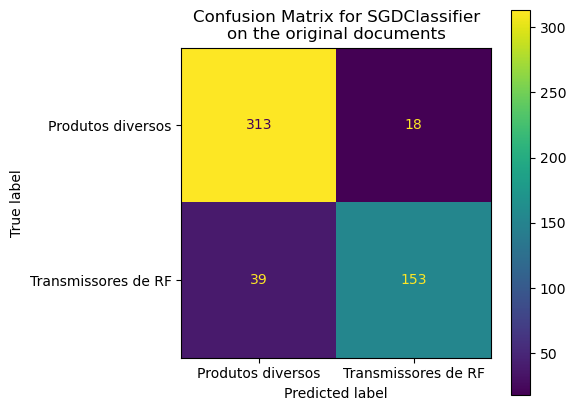

In [20]:
map_rf_transmitter = {0: 0, 1: 0, 2: 1}
X = df_cat_sample['doc']
y = df_cat_sample['rf_transmitter'].map(map_rf_transmitter)

target_names = ['Produtos diversos', 'Produtos transmissores de RF']
target_names_confusion = ['Produtos diversos', 'Transmissores de RF']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=724)

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizer)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

clf_sgd = SGDClassifier(loss='log_loss', penalty='l2',
                        alpha=1e-3, random_state=42,
                        max_iter=5, tol=None)

clf_sgd.fit(X_train_tfidf, y_train)
predicted = clf_sgd.predict(X_test_tfidf)

print('Accuracy of SGD classifier on training set: {:.3f}'
     .format(clf_sgd.score(X_train_tfidf, y_train)))
print('Accuracy of SGD classifier on test set: {:.3f}'
     .format(clf_sgd.score(X_test_tfidf, y_test)))
print('AUC of SGD classifier on test set: {:.3f}'
     .format(roc_auc_score(y_test,clf_sgd.predict_proba(X_test_tfidf)[:,1])))

print()
print(classification_report(y_test, predicted, target_names=target_names))

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_test, predicted, ax=ax)
ax.xaxis.set_ticklabels(target_names_confusion)
ax.yaxis.set_ticklabels(target_names_confusion)
_ = ax.set_title(f"Confusion Matrix for {clf_sgd.__class__.__name__}\non the original documents")

### Desempenho dos classificadores

Considerando a necessidade de se identificar corretamente produtos para telecomunicações não homologados e, portanto, evitar falsos negativos, adotaremos como métrica para comparação do desempenho dos classificadores a sensibilidade (_recall_).

A sensibilidade do primeiro classificador, construído para separar produtos diversos e produtos para telecomunicações, foi $0,79$. Quando alterado para separar os produtos em três grupos (produtos diversos, produtos para telecomunicações sem transmissão de radiofequência e produtos para telecomunicações tranmissores de radiofequência) a sensilidade para produtos de telecomunicações foi $0,00$ (produtos sem RF) e $0,83$ (transmissores de RF).

O segundo modelo treinado não foi capaz de identificar corretamente nenhum produto para telecomunicações sem transmissão de radiofrequência, ou seja, não foi capaz de fazer a correta separação dos produtos sobrepostos no espaço vetorial. 

Um terceiro classificador, construído para identificar produtos para telecomunicações transmissores de radiofrequência obteve um desempenho ligeiramente melhor com sensibilidade de $0,80$.

# Conclusão e próximos passos

O presente estudo apresentou uma análise exploratória dos dados extraídos do marketplace da Amazon e delineou uma linha base para avaliação do desempenhos de outros classificadores que venham a ser construídos para identificação de produtos para telecomunicações sujeitos a homologação compulsória anunciados em _marketplaces_.

O resultados foram limitados em razão dos poucos dados utilizados para treinar os classificadores, a amostra foi pequena e extraída de um único _marketplace_. 

Ainda assim, ficou demonstrada a viabilidade da construção de um classificador capaz de identificar produtos para telecomunicações sujeitos a homologação compulsória com desempenho satisfatório, que poderá ser obtido a partir da aplicação de técnicas de ciências de dados e aprendizagem de máquina, como por exemplo:

1. Rotulagem de dados em maior quantidade e de mais fontes, resultando em uma base de dados mais robusta para treinamento dos algoritmos de classificação;
2. Análise mais aprofundada e aplicação de técnicas para pré-processamento e limpeza de texto para redução de ruído existente na base de dados; e
3. Utilização de diferentes modelos de vetorização de texto e treinamento de diferentes algoritmos de aprendizagem de máquina mais adequados ao problema.

O maior desafio é a obtenção de uma base de dados rotulada robusta para ser utilizada no treinamento dos algoritmos de aprendizagem de máquina. Uma alternativa é a construção de uma plataforma colaborativa para que os fiscais da SFI possam contribuir na rotulagem dos dados, identificando se o produto de determinado anúncio é um produto para telecomunicações ou não.